# Projet Culinary Road Trip : Préparation & Analyse Géospatiale

**Contexte :** Ce notebook documente la phase d'exploration et de prétraitement des données pour l'application *Culinary Road Trip*.
L'objectif est de transformer le dataset brut TripAdvisor en une base de données qualifiée pour le calcul d'itinéraires.

**Étapes clés :**
1. Audit de la qualité des données
2. Justification des choix algorithmiques
3. Preuve de concept pour la recherche spatiale.
4. Pipeline de nettoyage et export pour la production.

## 1. Audit de la Qualité des Données
Avant toute utilisation, nous identifions les limites du dataset. L'analyse des valeurs manquantes est critique pour valider la faisabilité du routage géographique.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
import time

df = pd.read_csv("tripadvisor_european_restaurants.csv", engine='python')
df.head()

,restaurant_link,restaurant_name,original_location,country,region,province,city,address,latitude,longitude,...,excellent,very_good,average,poor,terrible,food,service,value,atmosphere,keywords
0,g10001637-d10002227,Le 147,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Ha...",France,Nouvelle-Aquitaine,Haute-Vienne,Saint-Jouvent,"10 Maison Neuve, 87510 Saint-Jouvent France",45.961674,1.169131,...,2.0,0.0,0.0,0.0,0.0,4.0,4.5,4.0,NaN,NaN
1,g10001637-d14975787,Le Saint Jouvent,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Ha...",France,Nouvelle-Aquitaine,Haute-Vienne,Saint-Jouvent,"16 Place de l Eglise, 87510 Saint-Jouvent France",45.957040,1.205480,...,2.0,2.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,g10002858-d4586832,Au Bout du Pont,"[""Europe"", ""France"", ""Centre-Val de Loire"", ""B...",France,Centre-Val de Loire,Berry,Rivarennes,"2 rue des Dames, 36800 Rivarennes France",46.635895,1.386133,...,3.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,g10002986-d3510044,Le Relais de Naiade,"[""Europe"", ""France"", ""Nouvelle-Aquitaine"", ""Co...",France,Nouvelle-Aquitaine,Correze,Lacelle,"9 avenue Porte de la Correze 19170, 19170 Lace...",45.642610,1.824460,...,1.0,0.0,0.0,0.0,0.0,4.5,4.5,4.5,NaN,NaN
4,g10022428-d9767191,Relais Du MontSeigne,"[""Europe"", ""France"", ""Occitanie"", ""Aveyron"", ""...",France,Occitanie,Aveyron,Saint-Laurent-de-Levezou,"route du Montseigne, 12620 Saint-Laurent-de-Le...",44.208860,2.960470,...,4.0,7.0,0.0,0.0,0.0,4.5,4.5,4.5,NaN,NaN


In [2]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19398 entries, 0 to 19397
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   restaurant_link                    19398 non-null  object 
 1   restaurant_name                    19398 non-null  object 
 2   original_location                  19398 non-null  object 
 3   country                            19398 non-null  object 
 4   region                             19398 non-null  object 
 5   province                           19366 non-null  object 
 6   city                               19375 non-null  object 
 7   address                            19397 non-null  object 
 8   latitude                           19131 non-null  float64
 9   longitude                          19131 non-null  float64
 10  claimed                            19394 non-null  object 
 11  awards                             5165 non-null   obj

In [3]:
print(df.nunique().sort_values(ascending=False).head(20))

restaurant_link                      19398
longitude                            18647
address                              18625
latitude                             18475
popularity_detailed                  18169
popularity_generic                   18136
restaurant_name                      16496
original_open_hours                   7105
original_location                     2929
city                                  2902
cuisines                              2209
features                              2134
top_tags                              1917
price_range                            990
total_reviews_count                    776
open_hours_per_week                    495
reviews_count_in_default_language      252
keywords                               218
meals                                  201
awards                                 190
dtype: int64


In [4]:
df.nunique()

,0
restaurant_link,19398
restaurant_name,16496
original_location,2929
country,1
region,14
province,92
city,2902
address,18625
latitude,18475
longitude,18647


In [5]:
# Taux de valeurs manquantes par colonne
missing = df.isna().mean().sort_values(ascending=False)
print("=== Valeurs manquantes (%) ===")
print((missing * 100).round(1))

=== Valeurs manquantes (%) ===
keywords                             98.9
special_diets                        87.1
atmosphere                           74.9
awards                               73.4
price_range                          67.8
features                             56.8
original_open_hours                  47.7
open_days_per_week                   47.7
open_hours_per_week                  47.7
working_shifts_per_week              47.7
food                                 36.8
value                                36.5
service                              36.5
meals                                31.5
price_level                          18.5
cuisines                             13.2
top_tags                              8.0
popularity_generic                    6.4
total_reviews_count                   6.4
avg_rating                            6.4
average                               6.4
terrible                              6.4
very_good                             6.4
exc

In [6]:
# Colonnes quasi vides (plus de 80% NaN)
empty_cols = missing[missing > 0.8].index.tolist()
if empty_cols:
    print("\n⚠️ Colonnes très incomplètes :", empty_cols)
else:
    print("\n✅ Aucune colonne avec >80% de NaN")


⚠️ Colonnes très incomplètes : ['keywords', 'special_diets']


## 2. Analyse Géospatiale & Choix Algorithmiques
Pour garantir la précision des itinéraires à l'échelle européenne, nous devons vérifier deux hypothèses techniques :
1.  **La courbure terrestre :** L'approximation Euclidienne est-elle viable ?
2.  **La densité :** La répartition des restaurants est-elle uniforme ?

In [7]:
# Coordonnées
lat_valid = df["latitude"].between(-90, 90).sum()
lon_valid = df["longitude"].between(-180, 180).sum()

print(f"\nCoordonnées valides : {lat_valid}/{len(df)} latitudes, {lon_valid}/{len(df)} longitudes")

# Ratings
if "rating" in df.columns:
    print("\nDistribution rating :")
    print(df["rating"].describe())
    print("\nValeurs uniques rating :", sorted(df["rating"].dropna().unique())[:10])

# Reviews
if "num_reviews" in df.columns:
    print("\nDistribution num_reviews :")
    print(df["num_reviews"].describe(percentiles=[.25, .5, .75, .9, .99]))


Coordonnées valides : 19131/19398 latitudes, 19131/19398 longitudes


In [8]:
# 1. Calcul de l'étendue géographique
lat_min, lat_max = df['latitude'].min(), df['latitude'].max()
lon_min, lon_max = df['longitude'].min(), df['longitude'].max()

print(f"Étendue Latitudinale: {lat_max - lat_min:.2f} degrés")
print(f"Étendue Longitudinale: {lon_max - lon_min:.2f} degrés")

# 2. Démonstration de la distorsion
# À 60° de latitude (Oslo), 1 degré de longitude = ~55km
# À 40° de latitude (Naples), 1 degré de longitude = ~85km
# C'est cette différence qui justifie l'usage de Haversine plutôt que Pythagore
def deg_lon_to_km(lat):
    return np.cos(np.radians(lat)) * 111.32

dist_oslo = deg_lon_to_km(60)
dist_naples = deg_lon_to_km(40)

print(f"\nDistance pour 1° de longitude à 60°N (Nord) : {dist_oslo:.2f} km")
print(f"Distance pour 1° de longitude à 40°N (Sud)  : {dist_naples:.2f} km")
print(f"Variation : {((dist_naples - dist_oslo) / dist_naples)*100:.1f}% d'erreur potentielle avec une distance euclidienne !")

Étendue Latitudinale: 9.55 degrés
Étendue Longitudinale: 14.64 degrés

Distance pour 1° de longitude à 60°N (Nord) : 55.66 km
Distance pour 1° de longitude à 40°N (Sud)  : 85.28 km
Variation : 34.7% d'erreur potentielle avec une distance euclidienne !


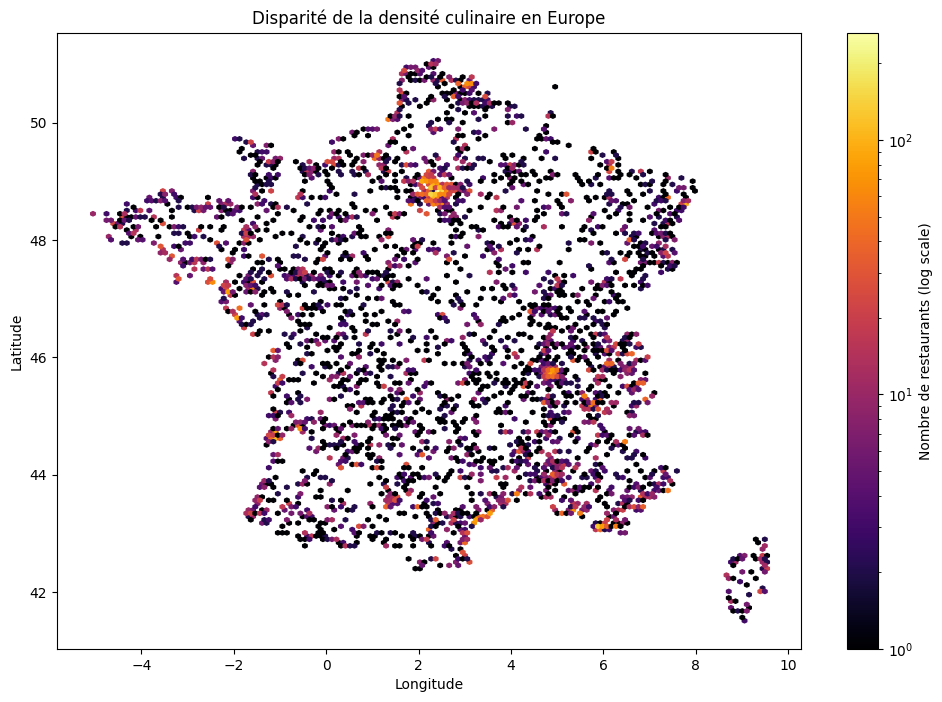

In [9]:
# Visualisation de la densité des restaurants
plt.figure(figsize=(12, 8))
# On filtre sur une zone "Europe" large pour la lisibilité
df_eur = df[
    (df['latitude'].between(35, 70)) &
    (df['longitude'].between(-10, 30))
]

plt.hexbin(
    df_eur['longitude'],
    df_eur['latitude'],
    gridsize=150,
    cmap='inferno',
    mincnt=1,
    bins='log'  # Échelle logarithmique pour voir les écarts massifs
)
plt.colorbar(label='Nombre de restaurants (log scale)')
plt.title('Disparité de la densité culinaire en Europe')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## 3. Preuve de Concept : Indexation Spatiale
Démonstration de l'utilisation d'un **BallTree** pour optimiser la recherche de voisins proches (Complexité $O(\log N)$) par rapport à une recherche naïve ($O(N)$).

In [10]:
# Préparation : Drop NaN et conversion en Radians
df_geo = df.dropna(subset=['latitude', 'longitude']).copy()
coords_rad = np.radians(df_geo[['latitude', 'longitude']].values)

# Construction de l'arbre
start = time.time()
tree = BallTree(coords_rad, metric='haversine')
end = time.time()
print(f"arbre BallTree construit sur {len(coords_rad)} points en {end - start:.2f} secondes.")

# Test : 5 voisins les plus proches d'un point arbitraire (ex: Paris)
query = np.radians(np.array([[48.85, 2.35]]))
dist, ind = tree.query(query, k=5)
print(f"✅ Recherche effectuée. Restaurant le plus proche à {dist[0][0]*6371:.3f} km.")

arbre BallTree construit sur 19131 points en 0.02 secondes.
✅ Recherche effectuée. Restaurant le plus proche à 0.382 km.


## 4. Pipeline de Nettoyage Final & Export
Génération du fichier `tripadvisor_clean.csv` optimisé pour l'application. Ce traitement applique les filtres décidés lors de l'analyse (suppression des sans-GPS, seuil d'avis significatif) et réduit la taille du fichier.

In [11]:
output_file = "tripadvisor_clean.csv"

# Sélection des colonnes utiles pour l'app (Roadtrip.py / Maps.py)
keep_cols = [
    "restaurant_name", "country", "city", "address",
    "latitude", "longitude",
    "avg_rating", "total_reviews_count",
    "price_level", "cuisines"
]
# On ne garde que les colonnes existantes pour éviter les erreurs
cols_to_keep = [c for c in keep_cols if c in df.columns]
df_clean = df[cols_to_keep].copy()

# Filtres Qualité
# Suppression des restaurants sans GPS ou sans note
df_clean = df_clean.dropna(subset=["latitude", "longitude", "avg_rating"])

# Fiabilité
# On garde uniquement les lieux avec au moins 10 avis
if "total_reviews_count" in df_clean.columns:
    df_clean = df_clean[df_clean["total_reviews_count"] >= 10]

# Échantillonnage
# On prend 15k restaurants aléatoires
if len(df_clean) > 15000:
    df_clean = df_clean.sample(n=15000, random_state=42)

# Export
df_clean.to_csv(output_file, index=False)

print(f"✅ Export terminé : {output_file}")
print(f"📉 Lignes restantes : {len(df_clean)}")

✅ Export terminé : tripadvisor_clean.csv
📉 Lignes restantes : 13544
